/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


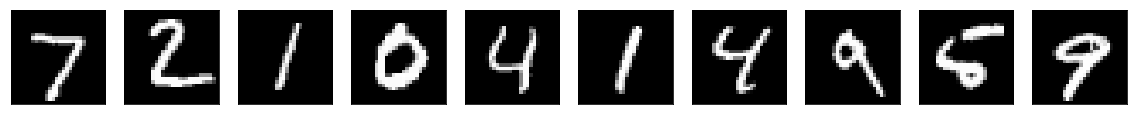

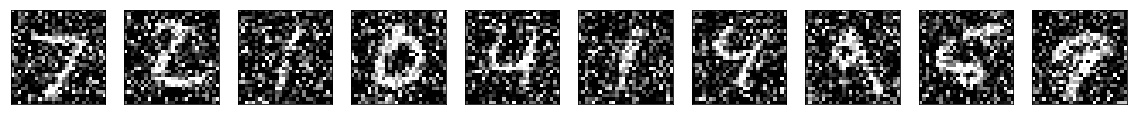

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_10_images(data):    
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

show_10_images(x_test)
show_10_images(x_test_noisy)

# Load the classifier

In [2]:
from classifier import create_model
import os
from keras.utils.np_utils import to_categorical


classifier = create_model()
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

weight_file = './weights/mnist_classifier.hd5'

if(os.path.exists(weight_file)):
    classifier.load_weights(weight_file)
else:
    classifier.fit(x_train, to_categorical(y_train),
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, to_categorical(y_test)), 
                    callbacks=[])

    classifier.save_weights(weight_file)

In [3]:
# Make test set predictions
x_pred = classifier.predict(x_test)

x_pred_digit = np.argmax(x_pred, axis=1)
x_pred_conf = np.max(x_pred, axis=1)

# Create the Autoencoders

In [4]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.regularizers import l1
from keras.models import Model

def create_model(i):
    n_hidden = 256
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Flatten()(x)
    encoded = Dense(n_hidden, activity_regularizer=l1(10e-8))(x)

    # representation is now size n_hidden

    x = Dense(7*7*32)(encoded)
    x = Reshape((7, 7, 32))(x)

    x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(input_img, decoded)
    
    # Change layer names to prevent weight sharing
    for i, layer in enumerate(model.layers):
        layer.name = 'layer'+str(i)+'_model'
        
    return model

Training autoencoder 0


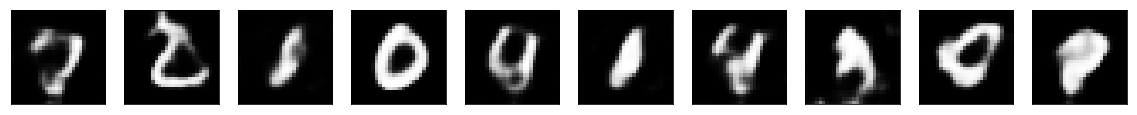

Training autoencoder 1


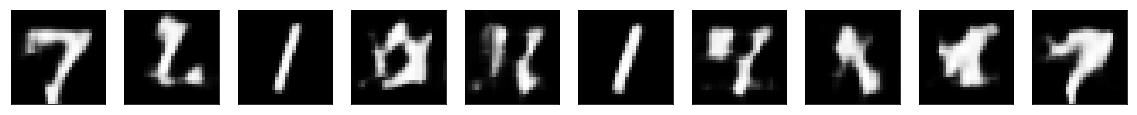

Training autoencoder 2


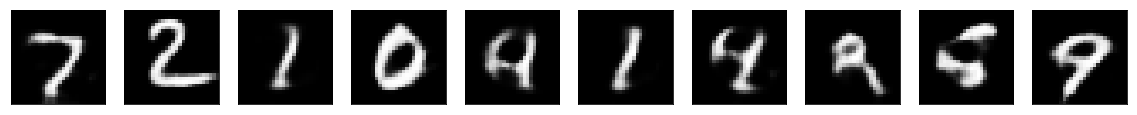

Training autoencoder 3


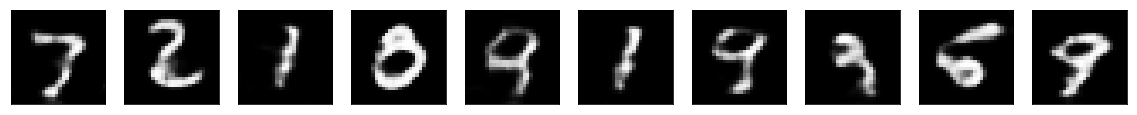

Training autoencoder 4


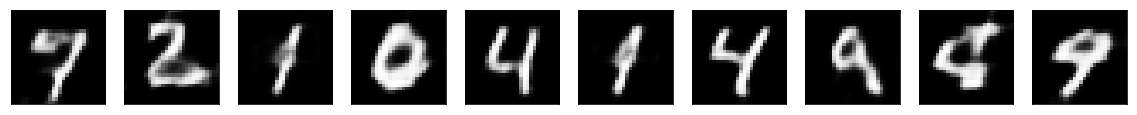

Training autoencoder 5


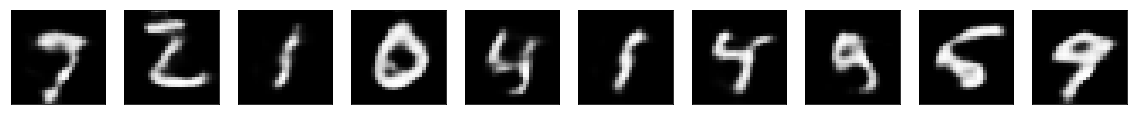

Training autoencoder 6


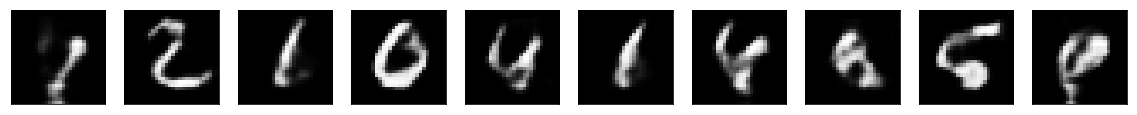

Training autoencoder 7


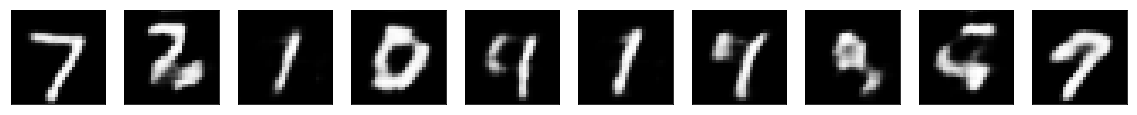

Training autoencoder 8


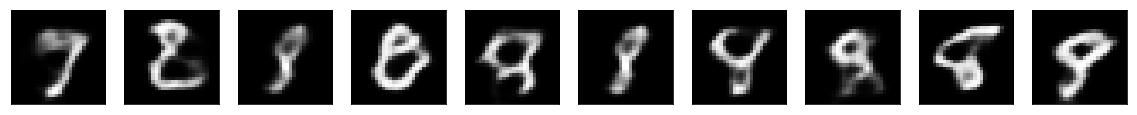

Training autoencoder 9


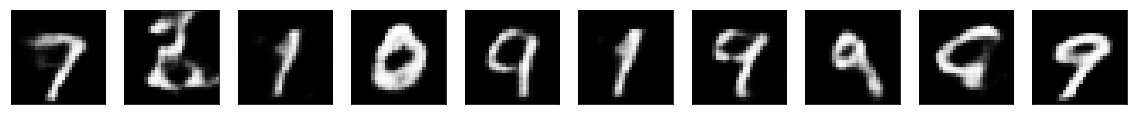

In [5]:
import os, gc
autoencoders = [create_model(i) for i in range(10)]

for i in range(10):
    print("Training autoencoder", i)
    autoencoders[i].compile(optimizer='adadelta', loss='binary_crossentropy')
    
    f = y_train == i
    x_train_noisy_filtered = x_train_noisy[f]
    x_train_filtered = x_train[f]
    
    f = y_test == i
    x_test_noisy_filtered = x_test_noisy[f]
    x_test_filtered = x_test[f]
    
    weight_file = './weights/mnist_autoencoder_digit_%d_binary_crossentropy_noise.hd5' % i
    if(os.path.exists(weight_file)):
        autoencoders[i].load_weights(weight_file)
    else:
        autoencoders[i].fit(x_train_noisy_filtered, x_train_filtered,
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(x_test_noisy_filtered, x_test_filtered),
                        callbacks=[])
        autoencoders[i].save_weights(weight_file)
    
    show_10_images(autoencoders[i].predict(x_test))    

In [6]:
from keras.layers import Lambda
from keras.losses import binary_crossentropy
import keras.backend as K 

input_ = Input(shape=(28, 28, 1))
predictions = [l(input_) for l in autoencoders]
losses = [
    Lambda(lambda x: binary_crossentropy(
        K.batch_flatten(input_), 
        K.batch_flatten(x))
    )(p) for p in predictions]

# min_loss = Lambda(lambda a: K.min(a))(losses)

# anomaly_detector = Model(input_, min_loss)
anomaly_detector = Model(input_, losses)

In [7]:
def min_max_scale(value, min_, max_):
    return (value - min_) / (max_ - min_)

def min_max_scale_array(values, mins, maxes):
    return (values - mins) / (maxes - mins)

mins = []
maxes = []

for i in range(10):
    losses = anomaly_detector.predict(x_train[y_train == i])
    mins.append(np.min(losses))
    maxes.append(np.max(losses))
    
mins = np.array(mins)
maxes = np.array(maxes)

In [8]:
from keras.layers import Lambda
from keras.losses import binary_crossentropy
import keras.backend as K 

input_ = Input(shape=(28, 28, 1))
recon_ = Input(shape=(28, 28, 1))
recon_loss = Lambda(lambda x: binary_crossentropy(
    K.batch_flatten(x[0]), 
    K.batch_flatten(x[1])
))([input_, recon_])

loss_calculator = Model(inputs=[input_, recon_], outputs=recon_loss)


def get_recons_loss(samples):
    pred = classifier.predict(samples)
    pred_class = np.argmax(pred, axis=1)
    pred_conf = np.max(pred, axis=1)

    recons_losses = np.array(anomaly_detector.predict(samples))
    
    recons_losses = min_max_scale_array(recons_losses.T, mins, maxes)
    recons_mins = np.min(recons_losses, axis=1)
    recons_argmins = np.argmin(recons_losses, axis=1)
    
    losses = recons_mins
    losses[recons_argmins != pred_class] = 1e15  
    
    return losses, pred

## Fashion MNIST

In [9]:
from keras.datasets import fashion_mnist
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

_, (fashion_x_test, _) = fashion_mnist.load_data()

fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_test = np.reshape(fashion_x_test, (len(x_test), 28, 28, 1))

In [10]:
recon_losses, preds = get_recons_loss(fashion_x_test)

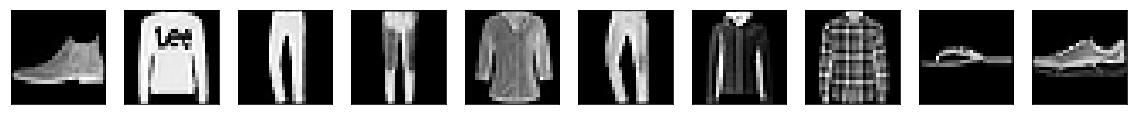

class
[2 8 1 1 6 9 7 5 2 4]

classifier confidence (higher is more confident)
[0.9, 0.49, 0.53, 0.41, 0.29, 0.24, 0.56, 0.19, 0.33, 0.41]

normalized recon loss (higher is worse)
[1000000000000000.0, 1.86, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0]


In [11]:
show_10_images(fashion_x_test)
print("class")
print(np.argmax(preds[:10], axis=-1))
print("\nclassifier confidence (higher is more confident)")
print([round(v, 2) for v in np.max(preds[:10], axis=-1)])
print("\nnormalized recon loss (higher is worse)")
print([round(v, 2) for v in recon_losses[:10]])

#### Calc AUROC

In [12]:
labels = len(x_test) * [0] + len(fashion_x_test) * [1]
test_samples = np.concatenate((x_test, fashion_x_test))

losses, _ = get_recons_loss(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.830850385


## EMNIST Letters

In [13]:
from torchvision.datasets import EMNIST

emnist_letters = EMNIST('./', "letters", train=False, download=True)
emnist_letters = emnist_letters.test_data.numpy()
emnist_letters = emnist_letters.astype('float32') / 255.

emnist_letters = np.reshape(emnist_letters, (len(emnist_letters), 28, 28, 1))
emnist_letters = np.swapaxes(emnist_letters, 1, 2)

In [14]:
recon_losses, preds = get_recons_loss(emnist_letters)

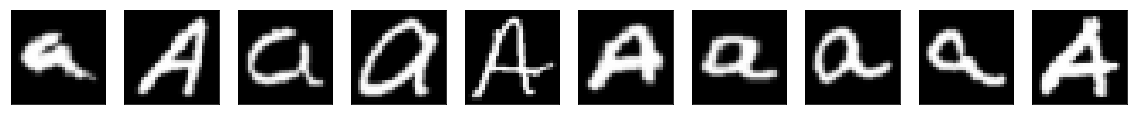

class
[4 4 2 0 4 0 2 2 4 4]

classifier confidence (higher is more confident)
[0.67, 0.89, 0.6, 0.9, 1.0, 0.49, 0.98, 1.0, 0.69, 0.98]

normalized recon loss (higher is worse)
[1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 0.41, 1000000000000000.0, 0.18, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0]


In [15]:
show_10_images(emnist_letters)
print("class")
print(np.argmax(preds[:10], axis=-1))
print("\nclassifier confidence (higher is more confident)")
print([round(v, 2) for v in np.max(preds[:10], axis=-1)])
print("\nnormalized recon loss (higher is worse)")
print([round(v, 2) for v in recon_losses[:10]])

#### Calc AUROC

In [16]:
labels = len(x_test) * [0] + len(emnist_letters) * [1]
test_samples = np.concatenate((x_test, emnist_letters))

losses, _ = get_recons_loss(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.8244365673076923


## Gaussian noise

In [17]:
mnist_mean = np.mean(x_train)
mnist_std = np.std(x_train)
gaussian_data = np.random.normal(mnist_mean, mnist_std, size=(10000, 28, 28, 1))

In [18]:
recon_losses, preds = get_recons_loss(gaussian_data)

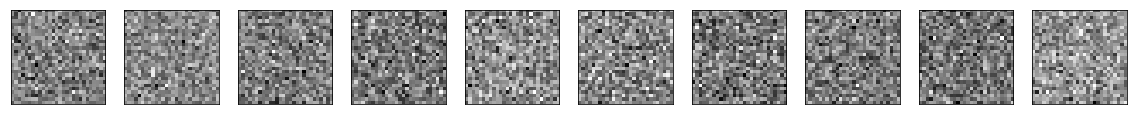

class
[5 8 2 2 2 6 2 2 1 3]

classifier confidence (higher is more confident)
[0.84, 0.29, 0.54, 0.5, 0.5, 0.84, 0.86, 0.88, 0.36, 0.93]

normalized recon loss (higher is worse)
[1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0]


In [19]:
show_10_images(gaussian_data)
print("class")
print(np.argmax(preds[:10], axis=-1))
print("\nclassifier confidence (higher is more confident)")
print([round(v, 2) for v in np.max(preds[:10], axis=-1)])
print("\nnormalized recon loss (higher is worse)")
print([round(v, 2) for v in recon_losses[:10]])

#### Calc AUROC

In [20]:
labels = len(x_test) * [0] + len(gaussian_data) * [1]
test_samples = np.concatenate((x_test, gaussian_data))

losses, _ = get_recons_loss(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.85517867


## Uniform noise

In [21]:
import math
b = math.sqrt(3.) * mnist_std
a = -b + mnist_mean
b += mnist_mean

uniform_data = np.random.uniform(low=a, high=b, size=(10000, 28, 28, 1))

uniform_data = uniform_data - np.mean(uniform_data) + mnist_mean
# uniform_data = np.clip(uniform_data, 0., 255.)

In [22]:
recon_losses, preds = get_recons_loss(uniform_data)

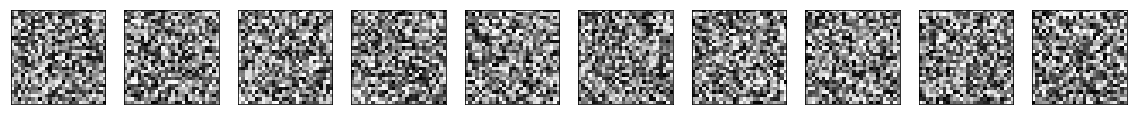

class
[2 7 2 3 2 7 7 1 1 2]

classifier confidence (higher is more confident)
[0.41, 0.35, 0.49, 0.5, 0.85, 0.45, 0.51, 0.45, 0.31, 0.87]

normalized recon loss (higher is worse)
[1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0]


In [23]:
show_10_images(uniform_data)
print("class")
print(np.argmax(preds[:10], axis=-1))
print("\nclassifier confidence (higher is more confident)")
print([round(v, 2) for v in np.max(preds[:10], axis=-1)])
print("\nnormalized recon loss (higher is worse)")
print([round(v, 2) for v in recon_losses[:10]])

#### Calc AUROC

In [24]:
labels = len(x_test) * [0] + len(uniform_data) * [1]
test_samples = np.concatenate((x_test, uniform_data))

losses, _ = get_recons_loss(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.855307235
